# Predicting number of failures

#### Load Libraries

In [2]:
import sys
sys.path.append('../')

!pip install fbprophet
!pip install pmdarima

from util.package import *
from util.preprocess import *
from dataset.dataset import Dataset
# from dataset.eda import EDA
from model.forecast import Forecast

from pylab import rcParams
rcParams['figure.figsize'] = 20, 4

#### Load dataset

In [3]:
## Read dataset and convert to timestamp
COLUMN = 'failuresCnt'

time_series = Dataset('../dataset/', True)
failures_data = time_series.read_trainset()
format_to = '%Y-%m-%d %H:%M:%S'
failures_data.time = pd.to_datetime(failures_data['time'], format=format_to , utc=False)
failures_data.sort_values('time', inplace=True)

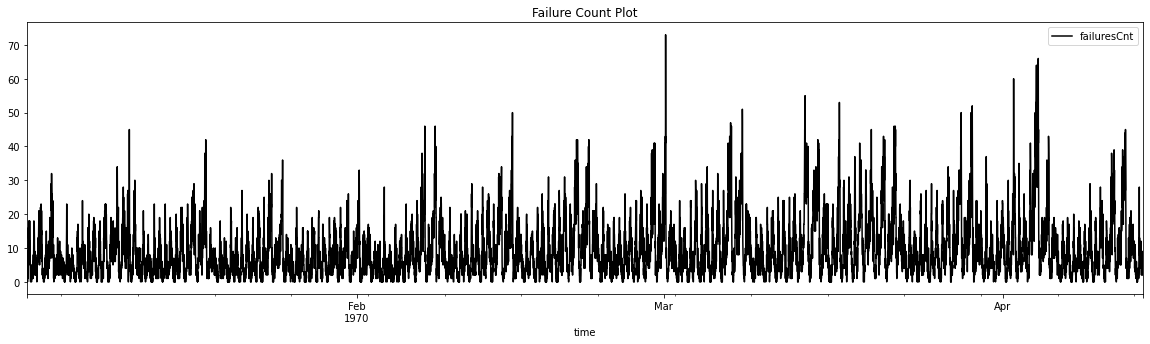

In [4]:
failures_data[COLUMN] = 1
failures_data = failures_data.set_index(['time'])
### data is starting from '1970-01-01 20:12:16'; ending at '1970-04-13 18:57:38'

# dsampling at 15 minutes interval
fd = failures_data.resample('15T').count()
fd.plot(style="k-", figsize=(20,5))
plt.title('Failure Count Plot')
plt.show()

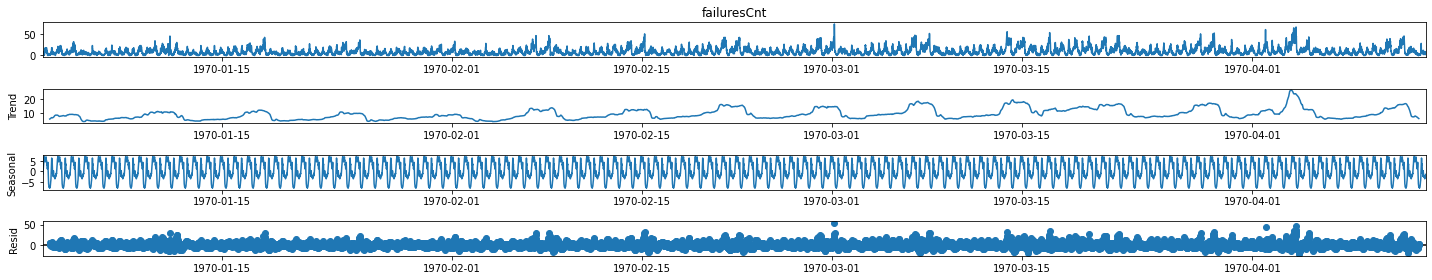

In [5]:
result = seasonal_decompose(fd.failuresCnt, model='additive',period=96)
result.plot()
plt.tight_layout()
plt.show()

#### observations
- dataset has trend and seasonality
- the trend is uptrend with periodicity
- the residual has pattern in it which requires further check
- Visually, the data do not seem to have stationary moving average
- there are spikes in the dataset (like in March), these could be outliers and can be removed or normalized

In [6]:
########## ACF and PACF Plot

- Handling the non-stationary average by taking differentiation of order 1 and then, validation using ACF and PACF graph.

In [7]:
fd['1difference'] = fd.failuresCnt - fd.failuresCnt.shift(1)
result=adfuller((fd['1difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -28.872915080845708,
 'criticalvalues': {'1%': -3.431021011779871,
  '10%': -2.5669278465492074,
  '5%': -2.8618365464471562},
 'icbest': 56467.574602675064,
 'nobs': 9748,
 'pvalue': 0.0,
 'usedlag': 38}

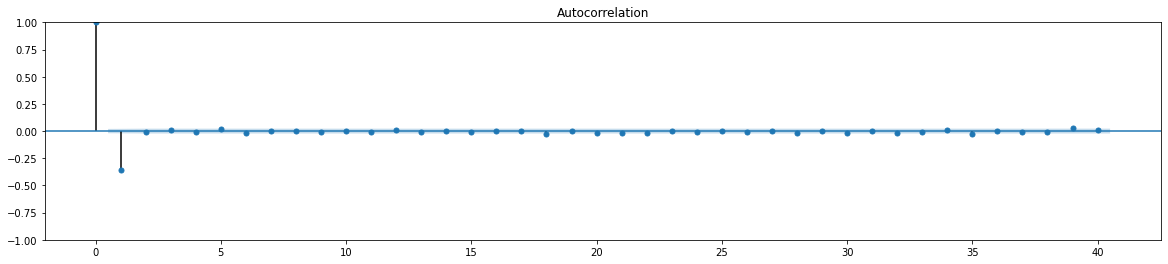

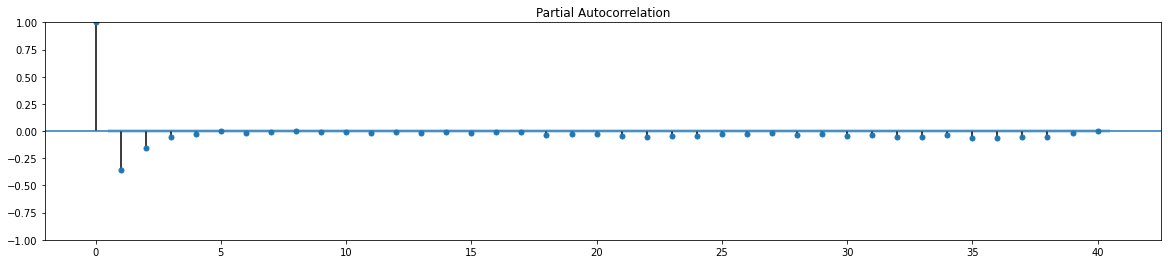

In [8]:
fig1=plot_acf(fd['1difference'].dropna()) 
fig2=plot_pacf(fd['1difference'].dropna())

- Partial Autocorrelation graph shows two spike at points 1,2 i.e., MA = (1,2) could be best possible values
- Autocorrelation graph shows single spike at lag = 1.

### Forecasting next hour failures count

In [9]:
### using ARIMA Model
### This parameter sets take lot of time to train hence
model = Forecast(fd[COLUMN], model_type='A')
result = model.forecasting().reset_index()
result.columns = ['Time','failure_count_ARIMA']
result.head()

,Time,failure_count_ARIMA
0,1970-04-13 19:00:00,5
1,1970-04-13 19:15:00,5
2,1970-04-13 19:30:00,5
3,1970-04-13 19:45:00,5
4,1970-04-13 20:00:00,5


In [10]:
### using Exponential Smoothing Model
model = Forecast(fd[COLUMN], model_type='E')
result = model.forecasting().reset_index()
result.columns = ['Time','failureCnt_ESM']
result.head()

,Time,failureCnt_ESM
0,1970-04-13 19:00:00,5
1,1970-04-13 19:15:00,5
2,1970-04-13 19:30:00,6
3,1970-04-13 19:45:00,6


In [11]:
### using Prophet Model
df = fd.loc[:, ['failuresCnt']].reset_index().copy()
df.columns = ['ds', 'y']
model = Forecast(df, model_type='P')
result = model.forecasting()
result.columns = ['Time','failureCnt_Prophet']
result.head()

,Time,failureCnt_Prophet
0,1970-04-13 19:00:00,4
1,1970-04-13 19:15:00,4
2,1970-04-13 19:30:00,4
3,1970-04-13 19:45:00,5


##### key observation - over a long term forecasting prophet performance is more closure to the actual failure pattern. ARIMA performance can be further improved by selecting optimal set of p,d,q for seasonal components and handling outliers (not covered in this assignment). 